# Analysis - Snitch Clothing Sales

**Descrição**: Esse é um conjunto de dados sintético, representando transações de vendas da loja _Snitch_,  
uma marca de vestuário fictícia na Índia, que simula dados reais de vendas em varejo com registros intocáveis (sujos),  
designados para alunos e profissionais que praticam limpeza de dados, análise exploratória (EDA), construção de dashboard.  

**Features**:
    - __Order_ID__: ID do pedido (inclui duplicatas)  
    - __Customer_Name__: Nome do cliente  
    - __Product_Category__: Categoria da roupa (Jeans, camisetas, etc.)  
    - __Product_Name__: Nome do produto  
    - __Units_Sold__: Quantidade vendida  
    - __Unit_Price__: Preço por unidade  
    - __Discount %__: Desconto aplicado  
    - __Sales_Amount__: Receita total após o desconto  
    - __Order_Date__: Data do pedido feito  
    - __City__: Nome da cidade  
    - __Segment__: Segmento do mercado (B2C, B2B, etc.)  
    - __Profit__: Lucro obtido da venda  

**O que fazer?**

> 1. Converter as datas para o formato correto
> 2. Produzir EDA para encontrar:  
    2.1. Categorias com mais vendas  
>   2.2. Impacto dos descontos nas vendas e lucro  
>   2.3. Tendência trimestral/mensal  
>   2.4. Performance dos segmentos  

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import seaborn as sns
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = [6, 5]
from datetime import datetime
import warnings
from scipy.stats import trim_mean
import os

In [2]:
warnings.filterwarnings('ignore')
print(f'Inicio: {str(datetime.now().strftime('%Y-%m-%d'))}')

Inicio: 2025-08-11


In [3]:
FILE_NAME = 'Snitch_Fashion_Sales.csv'
FOLDER_NAME = 'csv files'

if os.path.exists(FOLDER_NAME):
    full_path_csv = os.path.join(FOLDER_NAME, FILE_NAME)
else:
    new_folder = os.makedirs('csv_files')
    full_path = os.path.join(new_folder, FOLDER_NAME)

In [4]:
date_fixed = lambda x: datetime.strftime(x, '%Y-%m-%d')

df = pd.read_csv(
    full_path_csv, 
    encoding='utf-8', 
    na_filter=False, 
    thousands='|',
    float_precision='legacy',
    verbose=0
)

df.loc[1:5, ['Order_Date']].where(df['Product_Category'].isin(['Jeans', 'Shoes']))

,Order_Date
1,2025-07-15
2,NaN
3,18-06-2025
4,NaN
5,NaN


In [5]:
from typing import Optional, Union, Dict
import logging

logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

def find_empty_columns(
    df:pd.DataFrame, 
    show:bool=True, 
    return_as:str='dict', 
    log:bool=False
) -> Optional[Union[Dict[str, int], pd.Series]]:

    na_cols = [cname for cname in df.columns if np.count_nonzero(df[df[cname] == '']) > 0]

    if not na_cols:
        message = f'No null columns encountered'
        if log:
            logger.info(message)
        elif show:
            print(message)
        return None

    message = f'Null columns found:\n {na_cols}'

    if log:
        logger.warning(message)
    elif show:
        print(message)

    if return_as == 'dict':
        return na_cols.to_dict()
    elif return_as == 'series':
        return na_cols
    else:
        raise ValueError("Parâmetro 'retornar_como' deve ser 'dict' ou 'series'")

In [6]:
outcome = find_empty_columns(df, True, 'series', False)

Null columns found:
 ['Units_Sold', 'Unit_Price', 'Discount_%', 'Order_Date', 'Segment']


In [7]:
#outcome = np.array(outcome)
def exclude_nvalues(data:pd.DataFrame, cols:list) -> None:
    for cname in cols:
        data = data[data[cname] != '']

    return data

In [8]:
df = exclude_nvalues(df, outcome)

In [9]:
df.shape

(113, 12)

In [10]:
floatable_cols = []
for cname in df.select_dtypes(include=['object']).columns:
    try:
        pd.to_numeric(df[cname], errors='raise').astype(float)
        floatable_cols.append(cname)
    except ValueError:
        pass

In [11]:
df[floatable_cols] = df[floatable_cols].astype(float)

In [12]:
date = 'Order_Date'
df[date] = pd.to_datetime(df[date], dayfirst=True, errors='coerce')
df[date] = df[date].dt.strftime('%Y-%m-%d')


In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 113 entries, 34 to 2487
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Order_ID          113 non-null    int64  
 1   Customer_Name     113 non-null    object 
 2   Product_Category  113 non-null    object 
 3   Product_Name      113 non-null    object 
 4   Units_Sold        113 non-null    float64
 5   Unit_Price        113 non-null    float64
 6   Discount_%        113 non-null    float64
 7   Sales_Amount      113 non-null    float64
 8   Order_Date        41 non-null     object 
 9   City              113 non-null    object 
 10  Segment           113 non-null    object 
 11  Profit            113 non-null    float64
dtypes: float64(5), int64(1), object(6)
memory usage: 11.5+ KB


In [14]:
df.describe()

,Order_ID,Units_Sold,Unit_Price,Discount_%,Sales_Amount,Profit
count,113.000000,113.000000,113.000000,113.000000,113.000000,113.000000
mean,2092.008850,1.823009,2627.448673,0.687699,1336.600973,1145.817434
std,759.636832,2.595429,1405.682834,0.359471,4311.423465,1188.208598
min,1005.000000,-2.000000,470.680000,0.000000,-7518.330000,-992.610000
25%,1440.000000,0.000000,1378.760000,0.340000,-487.080000,131.480000
50%,1960.000000,1.000000,2496.170000,0.710000,79.500000,1179.440000
75%,2790.000000,4.000000,3891.070000,0.980000,2209.240000,2294.330000
max,3487.000000,6.000000,4962.700000,1.290000,29180.680000,2992.120000


In [15]:
df[['Units_Sold', 'Unit_Price', 'Sales_Amount', 'Profit']].quantile([0.25, 0.75]).T

,0.25,0.75
Units_Sold,0.00,4.00
Unit_Price,1378.76,3891.07
Sales_Amount,-487.08,2209.24
Profit,131.48,2294.33


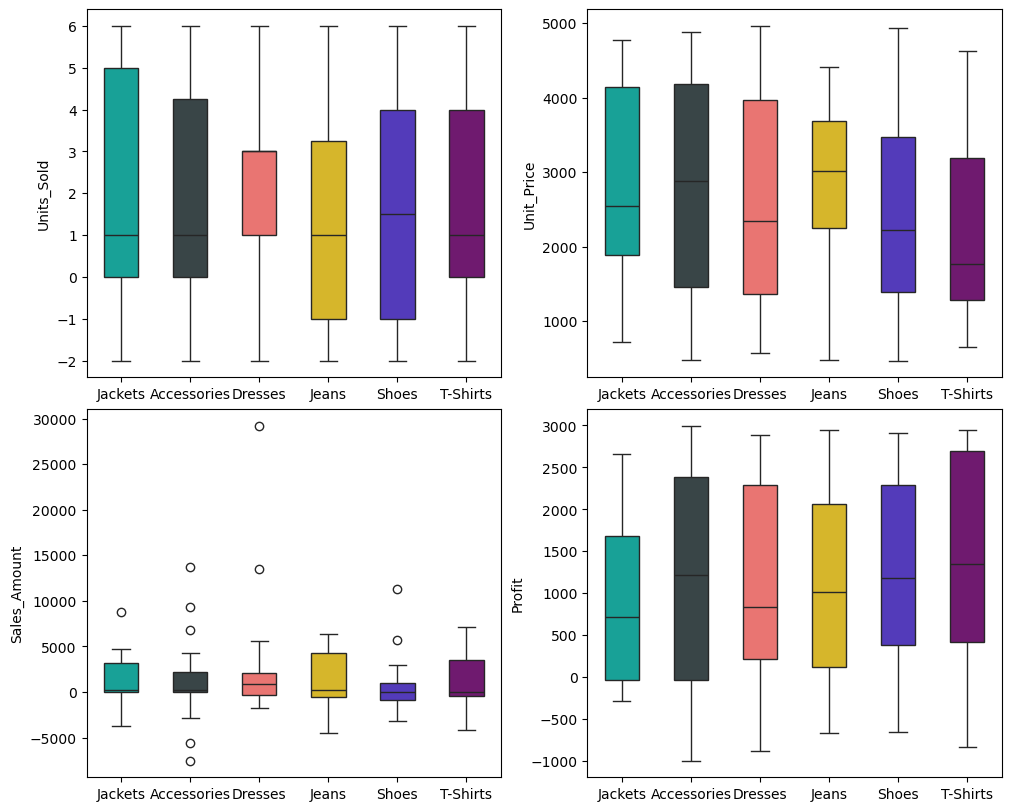

In [16]:
cols_plot = [cname for cname in df.select_dtypes(include=['float']).columns
            if not cname.endswith('%')]

colors = ['#01B8AA', '#374649', '#FD625E', '#F2C80F', '#4626cf', '#7d0c7d']

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 8), layout='constrained')
for column, ax in zip(cols_plot, axes.flatten()):
    bplot = sns.boxplot(x=df['Product_Category'], y=df[column].values, ax=ax, 
                        width=.5, palette=colors)

    ax.set_xlabel('')
    ax.set_ylabel(f'{column}')
plt.show()

In [17]:
df['Sales_Amount'].quantile([0.25, 0.75])

0.25    -487.08
0.75    2209.24
Name: Sales_Amount, dtype: float64

In [18]:
from sklearn.ensemble import IsolationForest

model = IsolationForest(contamination=0.1)
df['outlier_sales'] = model.fit_predict(df[['Sales_Amount']])

outliers_usold = df[df['outlier_sales'] == -1]
print(f'Outliers: {outliers_usold['Sales_Amount'].tolist()}')

Outliers: [13513.2, -7518.33, 29180.68, -4150.3, -5599.2, 7153.87, 11350.04, 13675.73, 8779.63, 6780.52, -4496.25, 9338.57]


In [19]:
df.columns

Index(['Order_ID', 'Customer_Name', 'Product_Category', 'Product_Name',
       'Units_Sold', 'Unit_Price', 'Discount_%', 'Sales_Amount', 'Order_Date',
       'City', 'Segment', 'Profit', 'outlier_sales'],
      dtype='object')

In [20]:
# Removendo os outliers
df = df[(df['Sales_Amount'] >= 0) & (df['Units_Sold'] >= 0) & (df['Profit'] >= 0)]

In [21]:
# Categorias com mais vendas
top_category_sales = df.groupby(by=['Product_Category'])['Units_Sold'].sum().sort_values(ascending=False)

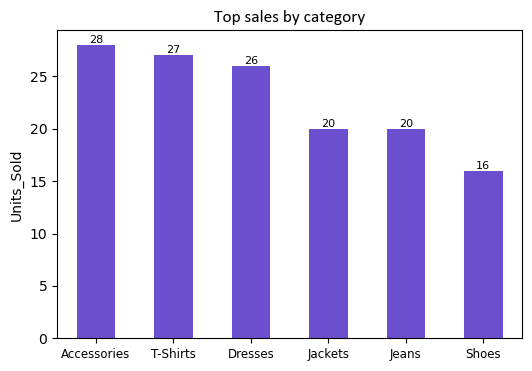

In [22]:
fig_size =  rcParams['figure.figsize'] = [6, 4]
plt.figure(figsize=(*fig_size, ))
ax = sns.barplot(x=top_category_sales.index, y=top_category_sales, color='#5f3ae4', width=.5)

ax.set_xlabel('')
ax.set_title(f'Top sales by category', fontsize=12.5, fontfamily='Calibri')
ax.bar_label(ax.containers[0], fontsize=8)
ax.set_xticklabels(labels=top_category_sales.index, fontsize=8.5)
plt.show()

### Impacto do desconto nas "vendas e lucro"

In [23]:
df.columns

Index(['Order_ID', 'Customer_Name', 'Product_Category', 'Product_Name',
       'Units_Sold', 'Unit_Price', 'Discount_%', 'Sales_Amount', 'Order_Date',
       'City', 'Segment', 'Profit', 'outlier_sales'],
      dtype='object')

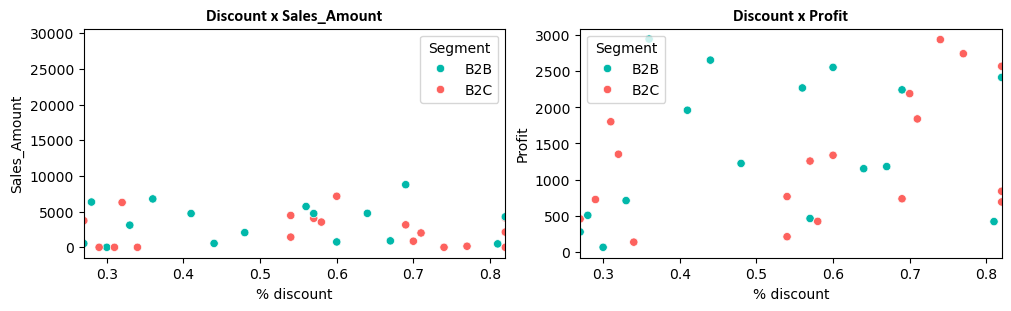

In [24]:
new_cols = [cname for cname in df.select_dtypes(include=['float']).columns.to_numpy().ravel()
           if cname in set(['Sales_Amount', 'Profit'])]

Q1 = np.absolute(np.quantile(df['Discount_%'], q=0.15, interpolation=None))
Q2 = np.absolute(np.quantile(df['Discount_%'], q=0.75, interpolation=None))

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 3), layout='constrained')

for column, ax in zip(new_cols, axes.flatten()):
    sns.scatterplot(data=df, x='Discount_%', y=f'{column}', ax=ax, markers='o',
                    color='#01B8AA', hue='Segment', palette=['#01B8AA', '#FD625E'])

    ax.set_xlabel(f'% discount', fontsize=10)
    ax.set_ylabel(f'{column}', fontsize=10)
    ax.set_title(f'Discount x {str(column)}', fontsize=12, fontweight='bold',
                fontfamily='Calibri')
    ax.set_xlim(Q1, Q2)

plt.show()

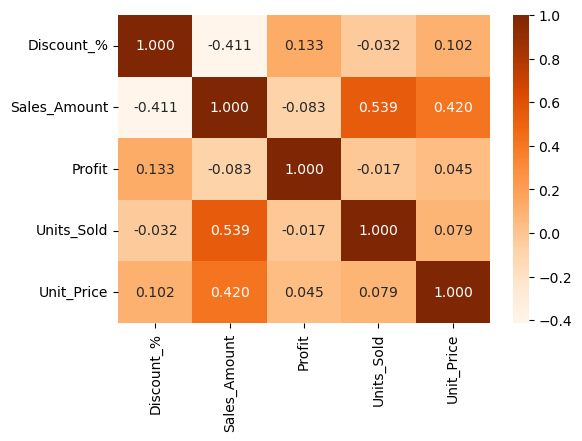

In [25]:
cols_corr = ['Discount_%', 'Sales_Amount', 'Profit', 'Units_Sold', 'Unit_Price']
df_corr = df[cols_corr].corr()
sns.heatmap(df_corr, annot=True, cmap='Oranges', fmt='.3f')
plt.show()

In [26]:
# Converte a data do pedido para 'datetime'
df['Order_Date'] = pd.to_datetime(df['Order_Date'])
df = df.set_index('Order_Date')

In [40]:
df_month_sales = df['Sales_Amount'].resample('M').sum()

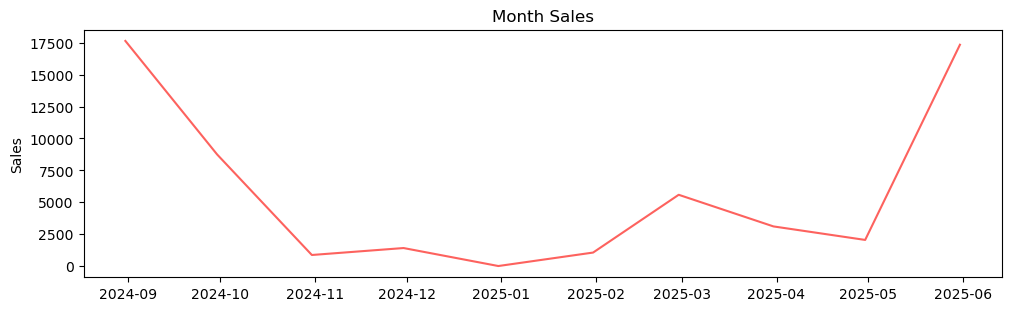

In [37]:
fig, ax = plt.subplots(figsize=(10, 3), layout='constrained')
sns.lineplot(df_month_sales, color='#FD625E', ax=ax)

ax.set_xlabel('')
ax.set_ylabel(f'Sales')
ax.set_title(f'Month Sales')
plt.show()